In [1]:
import gym
import gym_oscillator
import oscillator_cpp
from stable_baselines.common import set_global_seeds

from stable_baselines.common.policies import MlpPolicy,MlpLnLstmPolicy,FeedForwardPolicy
from stable_baselines.common.vec_env import DummyVecEnv,SubprocVecEnv,VecNormalize, VecEnv
from stable_baselines import PPO2
from stable_baselines.common.vec_env import VecEnv

import numpy as np
from matplotlib import pyplot as plt



/home/dmitriy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dmitriy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dmitriy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dmitriy/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

In [2]:
def make_env(env_id, rank, seed=0,):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    :param s_i: (bool) reward form, only one can be true
    """
    def _init():
        env = gym.make(env_id)
        print(env.reset().shape)
        return env
    set_global_seeds(seed)
    return _init

### To train with stablebaselines

In [3]:
#Our env
env_id = 'oscillator-v0'
time_steps = int(10e6)
#Number of cpus
num_cpu = 8
env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])

model = PPO2(MlpPolicy, env, verbose=1,tensorboard_log="MLP/")
#model.learn(time_steps)

(250,)
(250,)
(250,)
Instructions for updating:
Use keras.layers.flatten instead.
(250,)
(250,)
(250,)
(250,)
(250,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Save

In [4]:
# model.save('trained_models/model5layers.tf')

### Load model

In [5]:
env_id = 'oscillator-v0'
env = gym.make(env_id)
#Number of cpus
num_cpu = 1

env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])
model = PPO2(MlpPolicy, env, verbose=1,tensorboard_log="MLP/")
model = model.load('trained_models/Ps6_final_3')

(250,)
Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [ ]:
class oscillatorEnv(gym.Env):
  metadata = {'render.modes': ['human']}
  def __init__(self, len_state=250, ep_length=10000, nosc=1000, epsilon=0.03, frrms=0.1,random=False,
               sigmoid=False):

    """ 
    Init function:
    sigmoid: Function that we observe instead of original one: Bool
    len_state: shape of state that agent observes [250,1]: integer

    BVDP params
    nosc: number of oscillators: integer
    epsilon: coupling parameter: float
    frrms: width of the distribution of natural frequencies: float
    """

    super(oscillatorEnv, self).__init__()
    #Call init function and save params
    if random:
        epsilon = np.random.uniform(0.03,0.5)
    self.y = oscillator_cpp.init(nosc,epsilon,frrms)
    self.nosc = nosc
    self.epsilon = epsilon
    self.frrms = frrms
    
    self.ep_length = ep_length

    #Dimensionality of our observation space
    self.dim = 1
    self.action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)
    self.observation_space = Box(low=-1.5, high=1.5, shape=(len_state,), dtype=np.float32)

    #Meanfield for all neurons
    self.x_val = oscillator_cpp.Calc_mfx(self.y)
    self.y_val = oscillator_cpp.Calc_mfy(self.y)

    #Episode Done?
    self.done = False
    self.current_step = 0 

    #Our current state, with length(1,len_state)
    self.y_state = []
    self.x_state = []
    #Our actions 
    #self.actions = []
    
    self.len_state = len_state
    
    #Reset environment
    self.reset()

  def step(self, action):
      """
      Function that called at each step.

      action: signal to make perturbation: [[float]]
      returns: arrayed_version:np.array(1,len_state), 
      Reward: Our reward function :float, 
      done: Does it end? :Bool, 
      additional_information: Nothing to show :( :{} 
      """
      
      #Vectorized form for stable baselines
      val = float(action[0])
      self.y = oscillator_cpp.Pertrubation(self.y, val)
      self.y = oscillator_cpp.Make_step(self.y)
      
          
      #Calculate MeanField
      self.x_val = oscillator_cpp.Calc_mfx(self.y)
      self.y_val = oscillator_cpp.Calc_mfy(self.y)
      
      #if sigmoid:
          #self.x_val = sigmoid(self.x_val)
          #self.y_val = sigmoid(self.y_val)
      
      #Save our state
      self.y_state.append(self.y_val)
      self.x_state.append(self.x_val)
      
      #Check length of our state
      if len(self.y_state) > self.len_state:
          self.y_state = self.y_state[1:]
          self.x_state = self.x_state[1:]

      self.current_step += 1

      self.done = self.current_step >= self.ep_length

      #Make vectorized form
      arrayed_version = np.array(self.y_state)
      
      #if sigmoid:
          #arrayed_version = sigmoid(arrayed_version)
          
      return arrayed_version, self.Reward(self.x_val,self.x_state,val), self.done, {} 

  
  def reset(self):
    """
    Reset environment, and get a window 250 of self.len_state size

    Returns:arrayed_version:np.array(1,len_state)

    """
    self.current_step = 0 
    self.y_state = []
    self.x_state = []
    self.y = oscillator_cpp.init(self.nosc,self.epsilon,self.frrms)

    for i in range(self.len_state):
        oscillator_cpp.Make_step(self.y)
        
        self.x_val = oscillator_cpp.Calc_mfx(self.y)
        self.y_val = oscillator_cpp.Calc_mfy(self.y)

        self.y_state.append(self.y_val)
        self.x_state.append(self.x_val)
        
        #Check length of our state
        if len(self.y_state) > self.len_state:
            self.y_state = self.y_state[1:]
            self.x_state = self.x_state[1:]

    arrayed_version = np.array(self.y_state)    
    
    #if sigmoid:
        #arrayed_version = sigmoid(arrayed_version)
    return arrayed_version
    
  def render(self, mode='human', close=False):
    """
    Pass...
    """
    pass

  def Reward(self, x,x_state,action_value,baseline = False):
    """
    Super duper reward function, i am joking, just sum of absolute values which we supress + penalty for actions
    returns: float
    """
    
    return -(x-np.mean(x_state))**2 - 2*np.abs(action_value)

def sigmoid(x):
    x_0 = 1.2
    return 1. / (1. + np.exp(-x/x_0))

In [8]:
env = gym.make(env_id)
#Store rewards
rews_ = []
#Store observations
obs_ = []
obs = env.reset()
#Store actions
acs_ = []
#Store X,Y according to 
states_x = []
states_y = []

#Initial, non-suppresssion 
for i in range(25000):
    obs, rewards, dones, info = env.step([0])
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(0)
    rews_.append(rewards)

#Suppression stage
for i in range(25000):
    action, _states = model.predict(obs)
   
    obs, rewards, dones, info = env.step(action)
   
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(action)
    rews_.append(rewards)

#Final relaxation
for i in range(5000):
    obs, rewards, dones, info = env.step([0])
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(0)
    rews_.append(rewards)


### Graph plot

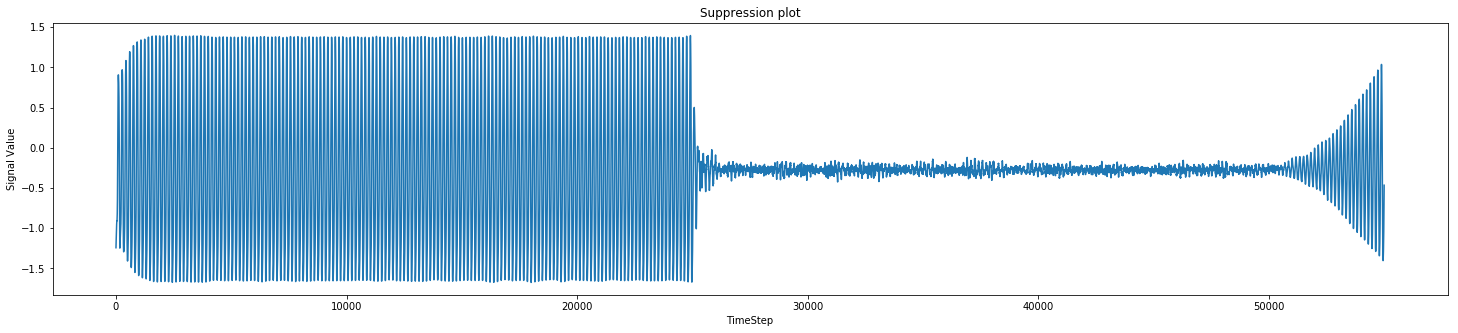

In [9]:
plt.figure(figsize=(25,5))
plt.title('Suppression plot')
plt.xlabel('TimeStep')
plt.ylabel('Signal Value')
plt.plot(states_x)

### Model score:

In [12]:
print(np.std(states_x[5000:25000])/np.std(states_x[30000:45000]))
s = (np.std(states_x[5000:25000])/np.std(states_x[30000:45000]))
print(np.sqrt(s))

27.266212742105157
5.22170592259897


In [11]:
print(np.mean(states_x[5000:150000]))

-0.2683076704695317


In [31]:
np.sqrt(1.10554209724429/0.0367348421348131)

5.48590841941973